# Definir un modele pour avoir simuler des electeurs

L'objectif est de definir un modele pour pouvoir creer un ensemble d'electeurs 
Pour cela je choisis de realiser un model agent-based ou il y a une notion d'influence entre les individus

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, expon
from mpl_toolkits.mplot3d import Axes3D

Matplotlib is building the font cache; this may take a moment.


### Je definis mon objet electeur pour pouvoir le manipuler ensuite 

In [8]:
class Elector:
    def __init__(self, position, preference_positions):
        self.position = np.array(position, dtype=float)  # Initial position on the 2D grid
        self.preference = self.closest_preference(preference_positions)
        self.preferences = self.ordered_preferences(preference_positions)

    def closest_preference(self, preference_positions):
        # Find the closest preference based on the current position
        distances = [np.linalg.norm(self.position - p) for p in preference_positions]
        return np.argmin(distances)
    
    def ordered_preferences(self, preference_positions):
        # Calculate distances to each preference position
        distances = [np.linalg.norm(self.position - p) for p in preference_positions]
        # Get the indices of preferences sorted by distance
        sorted_indices = np.argsort(distances)
        return sorted_indices

    def influence(self, other, step_size, random_factor_range=(0.1, 0.5)):
        # Calculate the direction towards the other elector's position
        direction = other.position - self.position
        # Normalize the direction vector
        direction_norm = direction / np.linalg.norm(direction)
        # Determine a random factor within the specified range
        random_factor = np.random.uniform(*random_factor_range)
        # Move towards the other elector's position by a random factor of the step size
        self.position += step_size * random_factor * direction_norm
        # Update preference based on new position
        self.preference = self.closest_preference(preference_positions)
        self.preferences = self.ordered_preferences(preference_positions)

# Example usage
preference_positions = np.array([
    [-4, -4],  # Preference 1 position
    [4, 4],    # Preference 2 position
    [0, 0]     # Preference 3 position
])

elector_position = np.array([1, 1])
other_elector_position = np.array([3, 3])
elector = Elector(elector_position, preference_positions)
other_elector = Elector(other_elector_position, preference_positions)

# Apply influence
step_size = 0.5
elector.influence(other_elector, step_size)

print("Elector's New Position:", elector.position)
print("Elector's Closest Preference:", elector.preference)
print("Elector's Ordered Preferences:", elector.preferences)

Elector's New Position: [1.13073645 1.13073645]
Elector's Closest Preference: 2
Elector's Ordered Preferences: [2 1 0]


### Je definis ma fonction pour simuler l'election

In [9]:
def simulate_election(num_electors, preference_positions, grid_size, num_steps, step_size):
    # Initialize electors with random positions on the grid
    electors = [Elector(np.random.rand(2) * grid_size, preference_positions) for _ in range(num_electors)]

    for step in range(num_steps):
        # Each elector interacts with another random elector
        for elector in electors:
            other = random.choice(electors)
            elector.influence(other, step_size)

    # Count the final preferences
    preferences = [elector.preference for elector in electors]
    preference_counts = [preferences.count(i) for i in range(len(preference_positions))]
    return electors, preference_counts

### Je veux pouvoir definir une grid de proba dependant de l'age pour placer pseudo aléatoirement l'electeur sur la grid 

/Users/matthieuburban/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


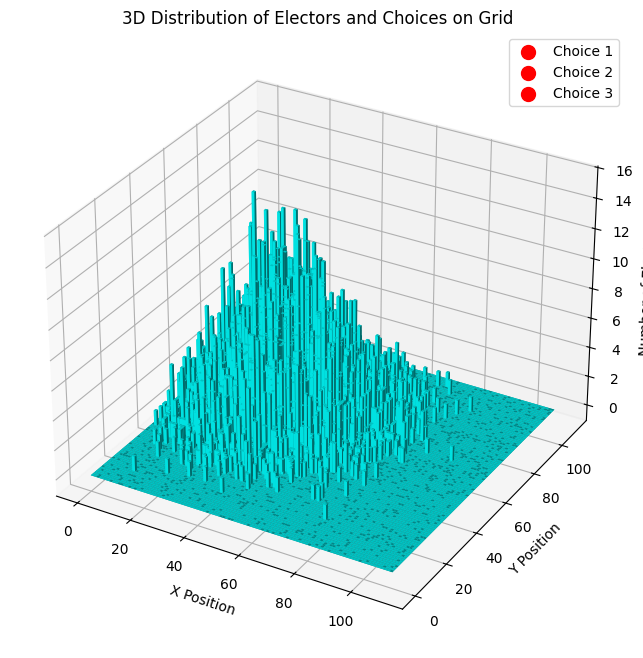

In [10]:
# Define the grid with higher granularity
grid_size = 110  # Increase this number for higher granularity
x = np.linspace(-5, 5, grid_size)
y = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x, y)

# Define the mean and covariance for the Gaussian distribution
mean = np.array([1, -2])  # Center of the distribution
covariance = np.array([[2, 0], [0, 2]])  # Standard deviation in x and y directions

# Create the Gaussian probability distribution
rv = multivariate_normal(mean, covariance)
pos = np.dstack((X, Y))
probability_matrix = rv.pdf(pos)

# Normalize the probability matrix so that it sums to 1
probability_matrix /= probability_matrix.sum()

# Flatten the probability matrix and positions for sampling
flat_probabilities = probability_matrix.flatten()
flat_positions = pos.reshape(grid_size**2, 2)

# Sample 100 elector positions based on the probability distribution
sampled_indices = np.random.choice(len(flat_positions), size=10000, p=flat_probabilities)
elector_positions = flat_positions[sampled_indices]

# Define choice positions
choice_positions = np.array([
    [-4, -4],  # Choice 1 position
    [4, 4],    # Choice 2 position
    [0, 0]     # Choice 3 position
])

# Count the number of electors at each grid position
elector_counts = np.zeros((grid_size, grid_size))
for pos in elector_positions:
    i = np.searchsorted(x, pos[0])
    j = np.searchsorted(y, pos[1])
    elector_counts[j, i] += 1

# Plot the 3D bar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
xpos, ypos = np.meshgrid(range(grid_size), range(grid_size), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = dy = np.ones_like(zpos)
dz = elector_counts.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='cyan')

# Plot choice positions
for choice_idx, choice_pos in enumerate(choice_positions):
    ax.scatter(choice_pos[0] + grid_size//2, choice_pos[1] + grid_size//2, 0, color='red', s=100, label=f'Choice {choice_idx + 1}')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Number of Electors')
ax.set_title('3D Distribution of Electors and Choices on Grid')
ax.legend()

plt.show()

### Deplacement de l'epicentre selon l'age de l'electeur 
Theorie perso on devient plus a droite avec l'age

In [11]:
def adjust_distribution_parameters(age, min_age=18, max_age=80):
    """
    Adjust the mean and covariance of the distribution based on the age of the elector.

    Parameters:
    - age: Age of the elector.
    - min_age: Minimum age in the range.
    - max_age: Maximum age in the range.

    Returns:
    - mean: Adjusted mean of the distribution.
    - covariance: Adjusted covariance of the distribution.
    """
    # Interpolate the mean between (-4, -4) and (4, 4)
    t = (age - min_age) / (max_age - min_age)  # Normalize age to [0, 1]
    mean = np.array([-4 + 8 * t, -4 + 8 * t])  # Linear interpolation between (-4, -4) and (4, 4)

    # Adjust the covariance based on age
    # For example, younger electors have a smaller spread, older electors have a larger spread
    base_covariance = np.array([[1, 0], [0, 1]])
    covariance = base_covariance * (1 + t)  # Increase spread with age

    return mean, covariance

# Example usage
age = 45  # Example age of an elector
mean, covariance = adjust_distribution_parameters(age)

print("Adjusted Mean:", mean)
print("Adjusted Covariance:", covariance)

Adjusted Mean: [-0.51612903 -0.51612903]
Adjusted Covariance: [[1.43548387 0.        ]
 [0.         1.43548387]]


### Definition de la courbe d'age ie la probabilite que l'electeur est cet age

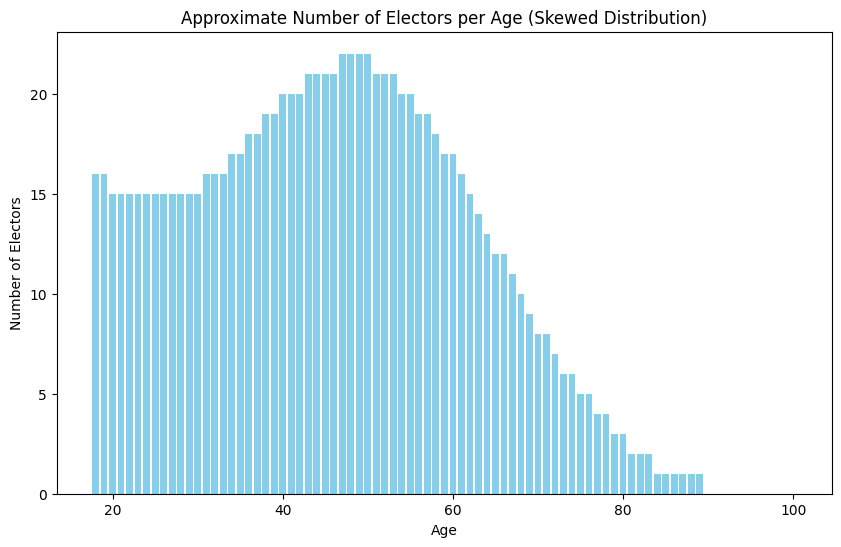

In [12]:
def approximate_electors_per_age_skewed(total_electors, min_age=18, max_age=100, peak_age=50, decay_rate=0.05):
    """
    Approximate the number of electors per age with a skewed distribution favoring younger ages.

    Parameters:
    - total_electors: Total number of electors to distribute across ages.
    - min_age: Minimum age in the range.
    - max_age: Maximum age in the range.
    - peak_age: Age at which the distribution peaks.
    - decay_rate: Rate at which the distribution decays after the peak age.

    Returns:
    - age_distribution: A dictionary with ages as keys and the number of electors as values.
    """
    ages = np.arange(min_age, max_age + 1)

    # Create a mixture of normal and exponential distributions
    normal_component = norm.pdf(ages, peak_age, 15)  # Normal distribution centered at peak_age
    exponential_component = expon.pdf(ages, scale=1/decay_rate)  # Exponential decay

    # Combine the distributions
    combined_pdf = normal_component + exponential_component

    # Normalize the combined PDF to sum to the total number of electors
    age_distribution = combined_pdf / combined_pdf.sum() * total_electors

    # Convert to a dictionary for easier lookup
    age_distribution_dict = {age: int(count) for age, count in zip(ages, age_distribution)}

    return age_distribution_dict

# Example usage
total_electors = 1000
age_distribution = approximate_electors_per_age_skewed(total_electors)

# Plot the age distribution
plt.figure(figsize=(10, 6))
plt.bar(age_distribution.keys(), age_distribution.values(), color='skyblue')
plt.xlabel('Age')
plt.ylabel('Number of Electors')
plt.title('Approximate Number of Electors per Age (Skewed Distribution)')
plt.show()

### Etude d'autres axes d'analyse 

Quels sont les autres criteres qui peuvent etre utiliser pour simuler une foule d'electeurs

Sexe : Les préférences politiques peuvent varier entre les hommes et les femmes, souvent en raison de priorités différentes concernant les politiques sociales, économiques et de santé.

Niveau d'Éducation : Le niveau d'éducation peut influencer les opinions politiques et la participation électorale. Les personnes ayant un niveau d'éducation plus élevé peuvent avoir des perspectives différentes sur des questions comme l'économie, l'environnement et les droits civiques.

Revenu et Statut Socio-Économique : Le revenu et le statut socio-économique influencent souvent les priorités politiques, notamment en ce qui concerne la fiscalité, les prestations sociales et les politiques économiques.

Lieu de Résidence : Les électeurs vivant en milieu urbain peuvent avoir des préoccupations différentes de ceux vivant en milieu rural, notamment en matière de transport, d'environnement et de développement économique.

Origine Ethnique et Culturelle : Les expériences et les perspectives culturelles peuvent influencer les priorités politiques, notamment en ce qui concerne les politiques d'immigration, les droits civiques et la représentation.

Religion : Les croyances religieuses peuvent influencer les opinions sur des questions morales et sociales, telles que l'avortement, le mariage homosexuel et l'éducation.

Profession : Le secteur d'activité peut influencer les opinions sur des questions spécifiques, telles que les politiques industrielles, les réglementations du travail et les politiques environnementales.

Historique Familial et Traditions Politiques : Les traditions politiques familiales peuvent influencer les préférences de vote, souvent par le biais de l'éducation et des discussions familiales.

Accès aux Médias et à l'Information : L'exposition à différentes sources d'information et de médias peut façonner les opinions politiques et influencer les décisions de vote.

Expériences Personnelles : Les expériences de vie personnelles, telles que le chômage, les problèmes de santé ou les interactions avec le système judiciaire, peuvent influencer les priorités politiques.

Engagement Civique et Participation Communautaire : L'implication dans des organisations communautaires ou des mouvements sociaux peut influencer les perspectives politiques et l'engagement électoral.

Perception de l'Économie : Les perceptions de la situation économique actuelle et future peuvent influencer les choix électoraux, notamment en ce qui concerne les politiques économiques et fiscales.

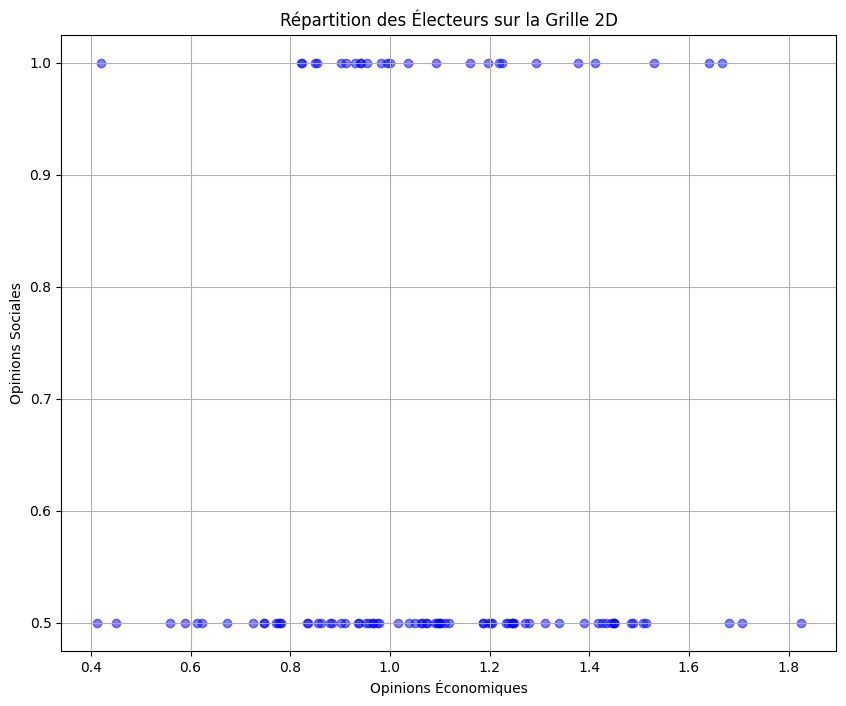

In [13]:
# Définir les distributions pour chaque critère
def generate_electors(num_electors):
    electors = []
    for _ in range(num_electors):
        sex = np.random.choice(['Male', 'Female'], p=[0.49, 0.51])
        education_level = np.random.normal(12, 4)  # Niveau d'éducation centré autour de 12 ans
        income = np.random.normal(50_000, 20_000)  # Revenu centré autour de 50,000
        socio_economic_status = np.random.choice(['Low', 'Middle', 'High'], p=[0.2, 0.6, 0.2])
        residence = np.random.choice(['Urban', 'Rural'], p=[0.7, 0.3])
        ethnicity = np.random.choice(['Group A', 'Group B', 'Group C'], p=[0.4, 0.35, 0.25])
        religion = np.random.choice(['Religion X', 'Religion Y', 'None'], p=[0.45, 0.35, 0.2])
        profession = np.random.choice(['Professional', 'Worker', 'Unemployed'], p=[0.4, 0.5, 0.1])
        family_history = np.random.choice(['Conservative', 'Liberal', 'Moderate'], p=[0.3, 0.3, 0.4])

        elector = {
            'sex': sex,
            'education_level': education_level,
            'income': income,
            'socio_economic_status': socio_economic_status,
            'residence': residence,
            'ethnicity': ethnicity,
            'religion': religion,
            'profession': profession,
            'family_history': family_history
        }
        electors.append(elector)
    return electors

# Fonction pour calculer la position sur la grille
def calculate_position(elector):
    # Exemple de calcul de position basé sur certains critères
    x_position = (elector['income'] / 100_000) + (elector['education_level'] / 20)
    y_position = 0.5 if elector['residence'] == 'Urban' else 1.0
    return x_position, y_position

# Générer une population d'électeurs
num_electors = 100
electors = generate_electors(num_electors)

# Calculer les positions des électeurs
positions = [calculate_position(elector) for elector in electors]

# Visualisation
x_positions, y_positions = zip(*positions)
plt.figure(figsize=(10, 8))
plt.scatter(x_positions, y_positions, color='blue', alpha=0.5)
plt.xlabel('Opinions Économiques')
plt.ylabel('Opinions Sociales')
plt.title('Répartition des Électeurs sur la Grille 2D')
plt.grid(True)
plt.show()

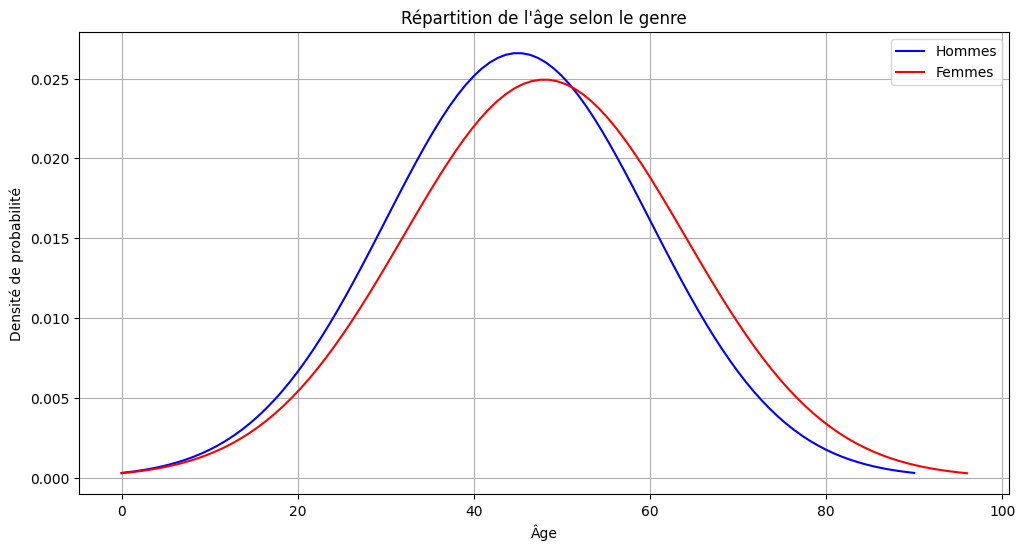

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Paramètres des distributions normales
mu_hommes = 45
sigma_hommes = 15
mu_femmes = 48
sigma_femmes = 16

# Générer des échantillons d'âge pour les hommes et les femmes
ages_hommes = np.random.normal(mu_hommes, sigma_hommes, 1000)
ages_femmes = np.random.normal(mu_femmes, sigma_femmes, 1000)

# Tracer les distributions
plt.figure(figsize=(12, 6))

# Densité de probabilité pour les hommes
x_hommes = np.linspace(mu_hommes - 3*sigma_hommes, mu_hommes + 3*sigma_hommes, 100)
pdf_hommes = norm.pdf(x_hommes, mu_hommes, sigma_hommes)
plt.plot(x_hommes, pdf_hommes, label='Hommes', color='blue')

# Densité de probabilité pour les femmes
x_femmes = np.linspace(mu_femmes - 3*sigma_femmes, mu_femmes + 3*sigma_femmes, 100)
pdf_femmes = norm.pdf(x_femmes, mu_femmes, sigma_femmes)
plt.plot(x_femmes, pdf_femmes, label='Femmes', color='red')

# Ajouter des titres et légendes
plt.title('Répartition de l\'âge selon le genre')
plt.xlabel('Âge')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()


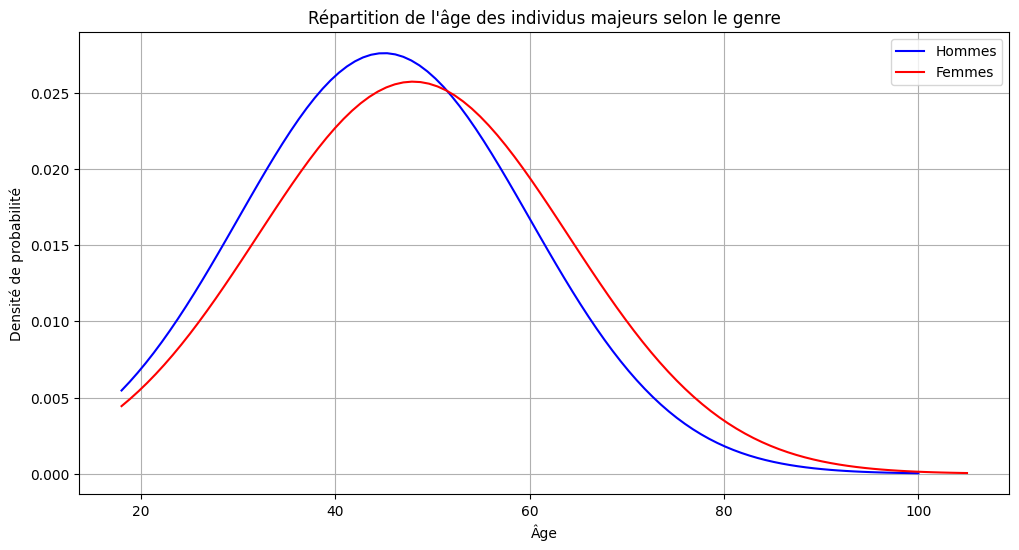

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# Paramètres des distributions normales tronquées
mu_hommes = 45
sigma_hommes = 15
mu_femmes = 48
sigma_femmes = 16

# Calculer les bornes pour la troncature
lower_bound = 18
upper_bound_hommes = 100  # Exemple de borne supérieure pour les hommes
upper_bound_femmes = 105  # Exemple de borne supérieure pour les femmes

# Calculer les paramètres a et b pour truncnorm
a_hommes = (lower_bound - mu_hommes) / sigma_hommes
b_hommes = (upper_bound_hommes - mu_hommes) / sigma_hommes
a_femmes = (lower_bound - mu_femmes) / sigma_femmes
b_femmes = (upper_bound_femmes - mu_femmes) / sigma_femmes

# Générer des échantillons d'âge pour les hommes et les femmes majeurs
ages_hommes = truncnorm.rvs(a_hommes, b_hommes, loc=mu_hommes, scale=sigma_hommes, size=1000)
ages_femmes = truncnorm.rvs(a_femmes, b_femmes, loc=mu_femmes, scale=sigma_femmes, size=1000)

# Tracer les distributions
plt.figure(figsize=(12, 6))

# Densité de probabilité pour les hommes majeurs
x_hommes = np.linspace(lower_bound, upper_bound_hommes, 100)
pdf_hommes = truncnorm.pdf(x_hommes, a_hommes, b_hommes, loc=mu_hommes, scale=sigma_hommes)
plt.plot(x_hommes, pdf_hommes, label='Hommes', color='blue')

# Densité de probabilité pour les femmes majeures
x_femmes = np.linspace(lower_bound, upper_bound_femmes, 100)
pdf_femmes = truncnorm.pdf(x_femmes, a_femmes, b_femmes, loc=mu_femmes, scale=sigma_femmes)
plt.plot(x_femmes, pdf_femmes, label='Femmes', color='red')

# Ajouter des titres et légendes
plt.title('Répartition de l\'âge des individus majeurs selon le genre')
plt.xlabel('Âge')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()


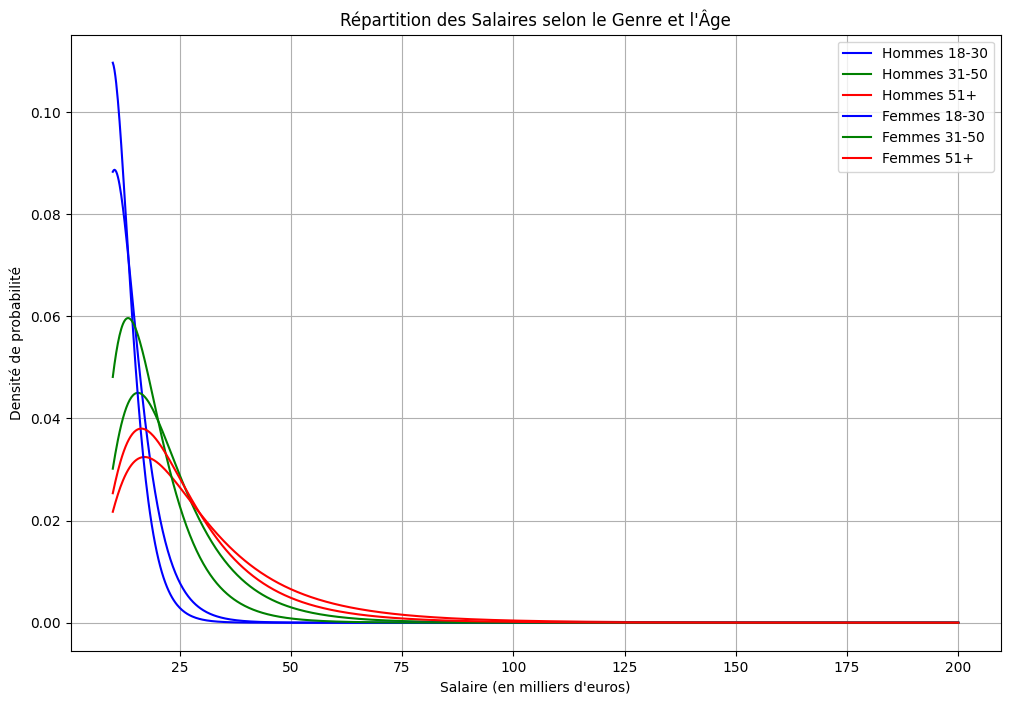

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Exemple de paramètres pour les distributions log-normales
params = {
    'Hommes': {
        '18-30': (2.5, 0.4),  # (mu, sigma)
        '31-50': (3.0, 0.5),
        '51+': (3.2, 0.6)
    },
    'Femmes': {
        '18-30': (2.4, 0.35),
        '31-50': (2.8, 0.45),
        '51+': (3.1, 0.55)
    }
}

# Tracer les distributions de salaires
plt.figure(figsize=(12, 8))

# Tranches d'âge
age_groups = ['18-30', '31-50', '51+']
colors = ['blue', 'green', 'red']

# Tracer pour les hommes et les femmes
for gender in ['Hommes', 'Femmes']:
    for age_group, color in zip(age_groups, colors):
        mu, sigma = params[gender][age_group]
        x = np.linspace(10, 200, 1000)  # Plage de salaires en milliers d'euros
        pdf = lognorm.pdf(x, sigma, scale=np.exp(mu))
        plt.plot(x, pdf, label=f'{gender} {age_group}', color=color)

# Ajouter des titres et légendes
plt.title('Répartition des Salaires selon le Genre et l\'Âge')
plt.xlabel('Salaire (en milliers d\'euros)')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
!pip install statsmodels

600629.37s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 988.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 1.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [19]:
import numpy as np
import statsmodels.api as sm

# Exemple de données
salaire = np.array([30000, 45000, 60000, 75000, 90000])
vote = np.array([0, 0, 1, 1, 1])  # 0: Parti B, 1: Parti A

# Ajouter une constante pour l'intercept
X = sm.add_constant(salaire)

# Modèle de régression logistique
model = sm.Logit(vote, X)
result = model.fit()

# Afficher les résultats
print(result.summary())


         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                          Logit   Df Residuals:                        3
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:                   1.000
Time:                        21:46:52   Log-Likelihood:            -7.9919e-08
converged:                      False   LL-Null:                       -3.3651
Covariance Type:            nonrobust   LLR p-value:                  0.009480
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -123.5811   4.96e+04     -0.002      0.998   -9.73e+04     9.7e+04
x1             0.0024      1.081      0.002      0.998      -2.11

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
